### Data preprocessing

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
store = pd.read_csv('../data/preprocessed_store.csv')
train = pd.read_csv('../data/preprocessed_train.csv', index_col='Date', parse_dates=True)
test = pd.read_csv('../data/preprocessed_test.csv')
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekofYear'] = train.index.isocalendar().week

train['SalesPerCustomer'] = train['Sales'] / train['Customers']
train_store_closed = train[(train.Open == 0)]
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)
store.fillna(0, inplace=True)
store.isnull().sum().sum()
test.fillna(1, inplace=True)
test.isnull().sum().sum()


train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
train=train.drop(columns=train[(train.Open == 1) & (train.Sales == 0)].index)
train.Customers.describe()





C:\Users\jerry\AppData\Local\Temp\ipykernel_30376\760136307.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../data/preprocessed_train.csv', index_col='Date', parse_dates=True)


count    844338.000000
mean        762.777166
std         401.194153
min           8.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64

In [59]:
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head(1000)

In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,5,4655,560,1,1,0,0,2014,11,...,8.312500,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
996,2,4,5009,624,1,1,0,0,2014,11,...,8.027244,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
997,2,3,6818,776,1,1,0,0,2014,11,...,8.786082,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
998,2,2,5651,601,1,1,0,0,2014,11,...,9.402662,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


### Time Series Analysis

In [60]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf


In this section we will consider only one store from each store type(a, b, c, d).

In [61]:
pd.plotting.register_matplotlib_converters()

In [62]:
# Data Preparation: input should be float type

# our Sales data is int type so lets make it float
train['Sales'] = train['Sales'] * 1.00

train['Sales'].head()

Date
2015-07-31     5263.0
2015-07-31     6064.0
2015-07-31     8314.0
2015-07-31    13995.0
2015-07-31     4822.0
Name: Sales, dtype: float64

In [63]:
train.Store.unique()

array([   1,    2,    3, ..., 1115,  876,  292], dtype=int64)

In [64]:
train.Store.nunique()

1115

<Axes: xlabel='Date'>

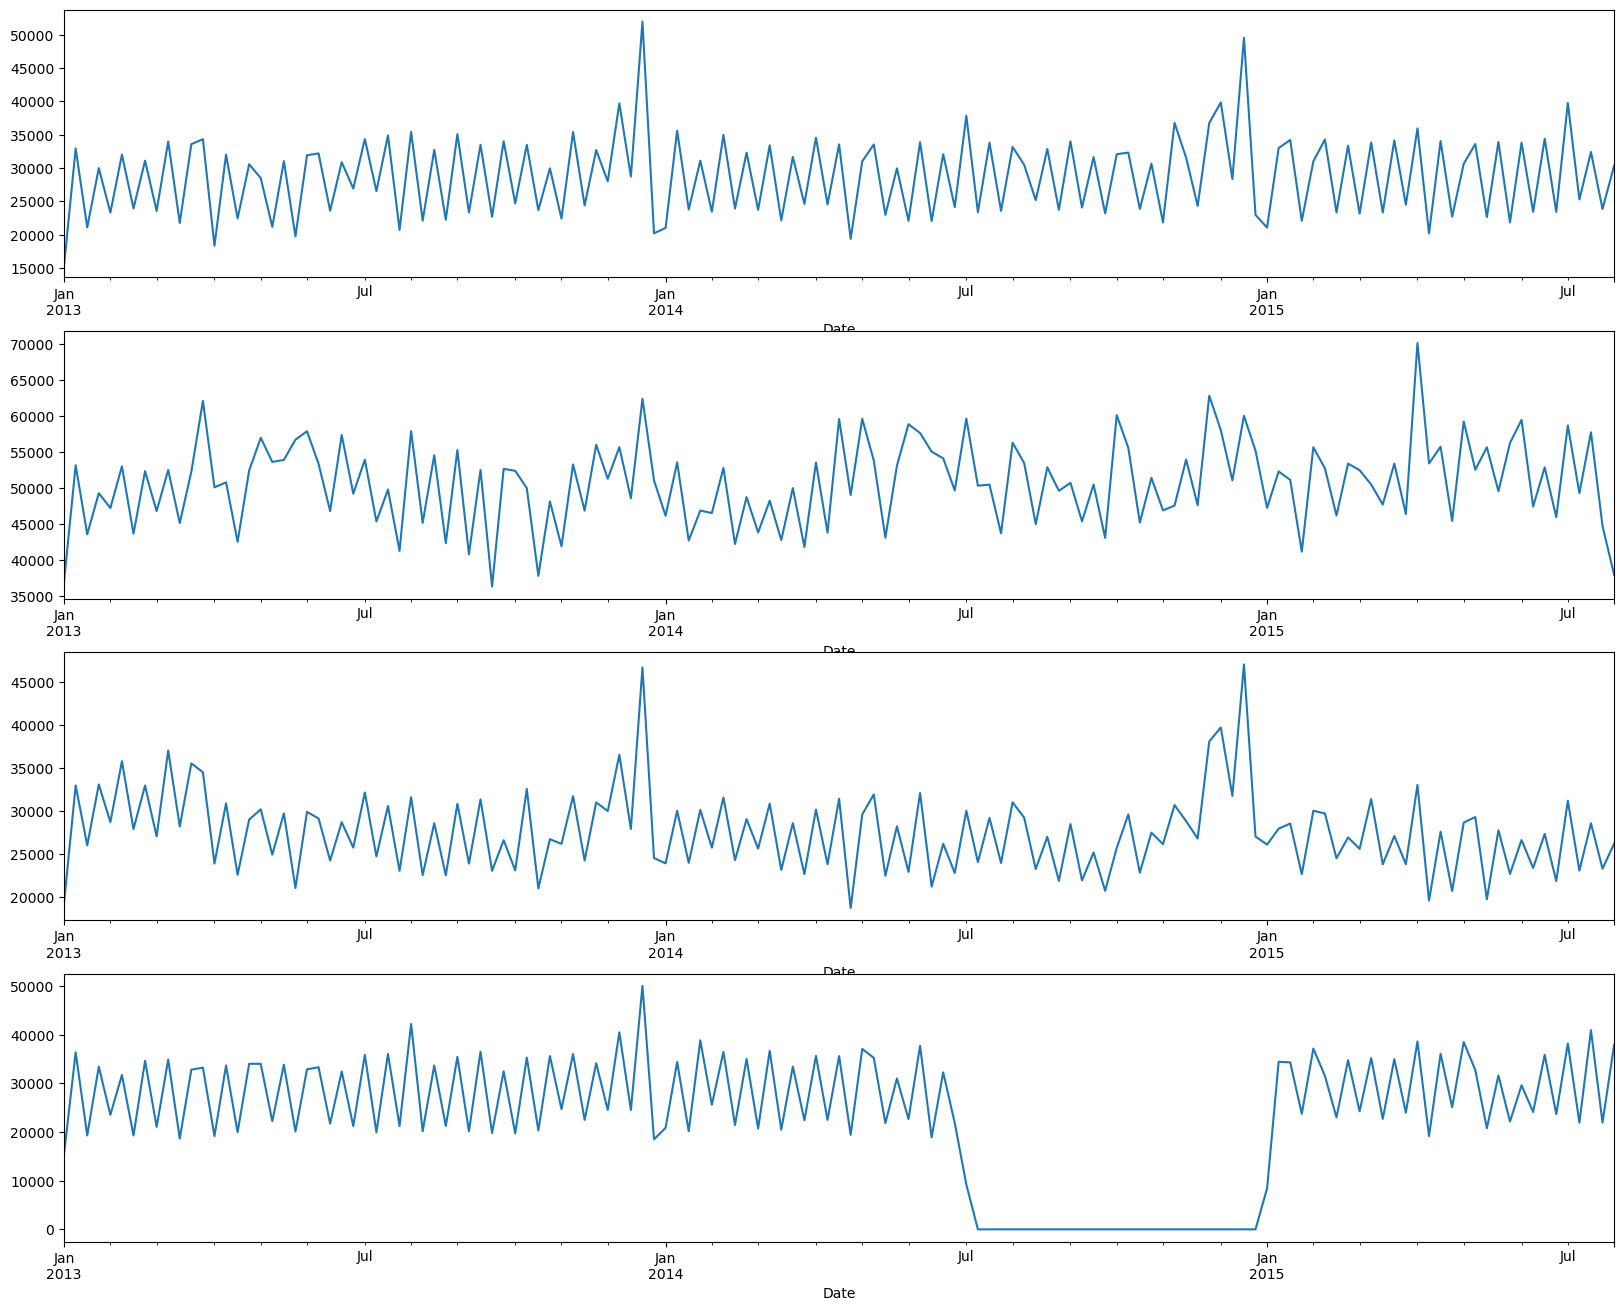

In [94]:
# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True)
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

frame, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (20, 16))

# Visualize Trend
sales_a.resample('w').sum().plot(ax = ax1)
sales_b.resample('w').sum().plot(ax = ax2)
sales_c.resample('w').sum().plot(ax = ax3)
sales_d.resample('w').sum().plot(ax = ax4)


# will be used to resample the speed column of our DataFrame
#The 'W' indicates we want to resample by week. At the bottom of this post is a summary of different time frames.
# You could use for Day = d, MOnth = m, Year = y

From the above chart, we can see that the sales of store types A and C are highest at the end of the year, particularly in December, which coincides with the Christmas season. This seasonality likely explains the increase in sales. However, sales decrease towards the end of the month. We do not observe a similar trend for stores B and D, possibly because there is no data for that period. A possible reason could be that these stores were closed.

# stationarity of Time Seriese

Stationarity means that the statistical properties of a time series do not change over time. Some stationary data is (constant mean, constant variance and constant covariance with time).

### There are 2 ways to test the stationarity of time series
* A) Rolling Mean: Visualization
* B) Dicky - Fuller test: Statistical test

**A) Rolling Mean:** A rolling analysis of a time series model is often used to assess the model's stability over time. The window is rolled (slid across the data) on a weekly basis, in which the average is taken on a weekly basis. Rolling Statistics is a visualization test, where we can compare the original data with the rolled data and check if the data is stationary or not.

**B) Dicky -Fuller test:** This test provides us the statistical data such as p-value to understand whether we can reject the null hypothesis. If p-value is less than the critical value (say 0.5), we will reject the null hypothesis and say that data is stationary.

In [95]:
# def test_stationarity(timeseries):
#     # Determine rolling statistics
#     roll_mean = timeseries.rolling(window=7).mean()
#     roll_std = timeseries.rolling(window=7).std()

#     # plotting rolling statistics
#     plt.subplots(figsize = (16, 6))
#     original = plt.plot(timeseries.resample('w').mean(), color='blue', linewidth= 3, label='Original')
#     rolling_mean_plot = plt.plot(roll_mean.resample('w').mean(), color='red', linewidth= 3, label='Rolling Mean')
#     rolling_std_plot = plt.plot(roll_std.resample('w').mean(), color='green', linewidth= 3, label='Rolling Std')
    
#     plt.legend(loc='best')
#     plt.show()

#     # Performing Dickey-Fuller test
#     print('Result of Dickey-Fuller test:')
#     result = adfuller(timeseries, autolag='AIC')

#     print('ADF Statistics: %f' % result[0])
#     print('P-value: %f' % result[1])
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print(key, value)

# lets create a functions to test the stationarity 
def test_stationarity(timeseries):
    # Determine rolling statestics 
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
    
    # plotting rolling statestics 
    plt.subplots(figsize = (16, 6))
    orginal = plt.plot(timeseries.resample('w').mean(), color='blue',linewidth= 3, label='Orginal')
    roll_mean = plt.plot(roll_mean.resample('w').mean(), color='red',linewidth= 3, label='Rolling Mean')
    roll_mean = plt.plot(roll_std.resample('w').mean(), color='green',linewidth= 3, label='Rolling Std')
    
    plt.legend(loc='best')
    plt.show()
    
    # Performing Dickey-Fuller test 
    print('Result of Dickey-Fuller test:')
    result= adfuller(timeseries, autolag='AIC')
    
    print('ADF Statestics: %f' %result[0])
    print('P-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)


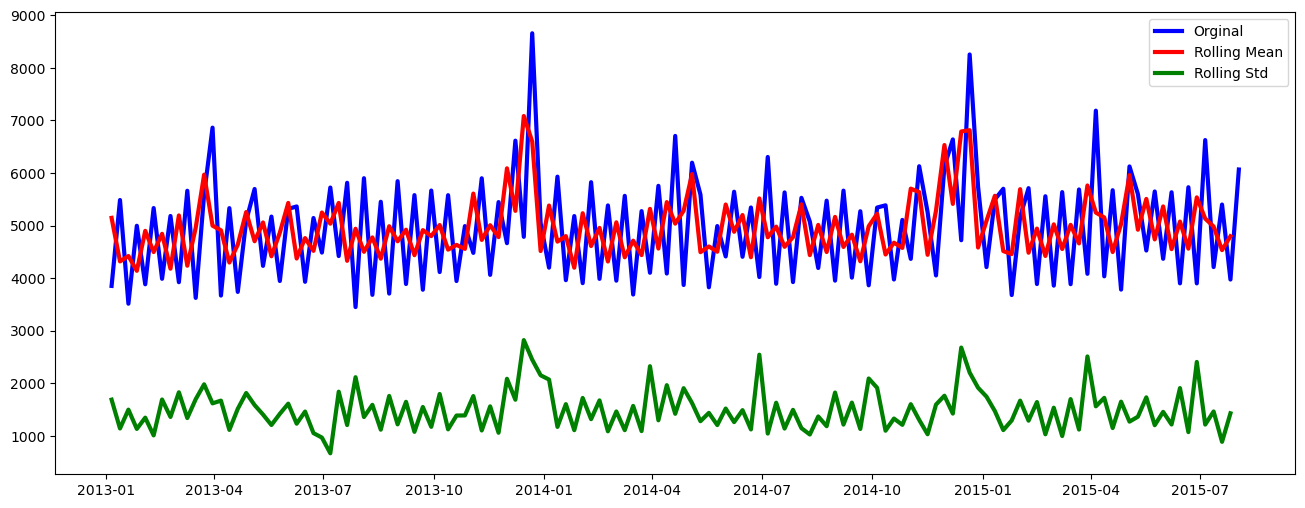

Result of Dickey-Fuller test:
ADF Statestics: -5.292708
P-value: 0.000006
Critical Values:
1% -3.438915730045254
5% -2.8653205426302253
10% -2.5687831424305845


In [93]:
test_stationarity(sales_a)

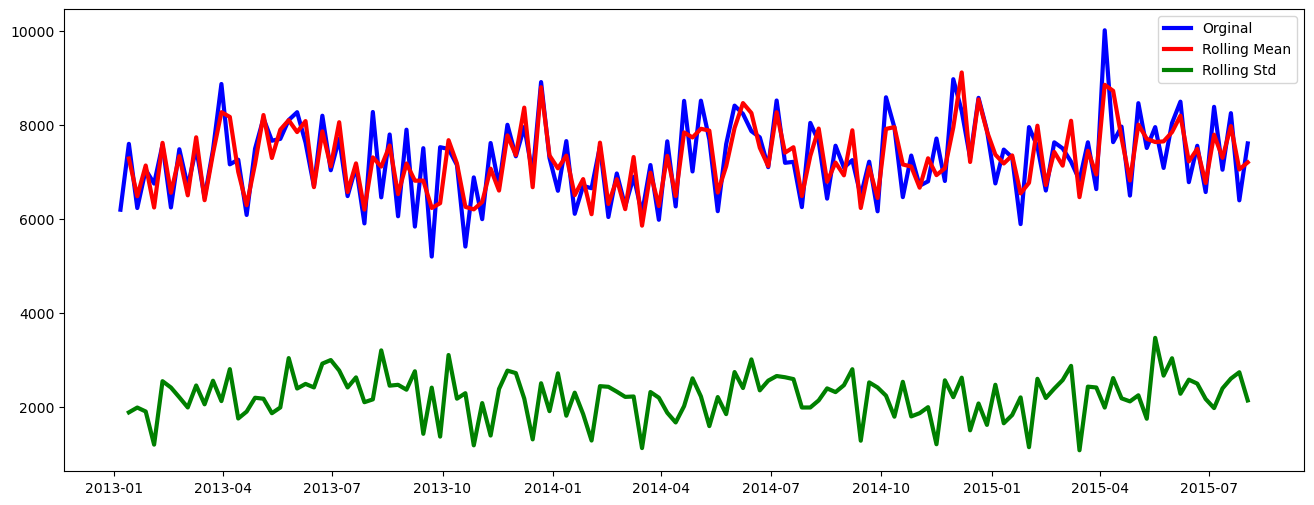

Result of Dickey-Fuller test:
ADF Statestics: -5.660918
P-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [96]:
test_stationarity(sales_b)

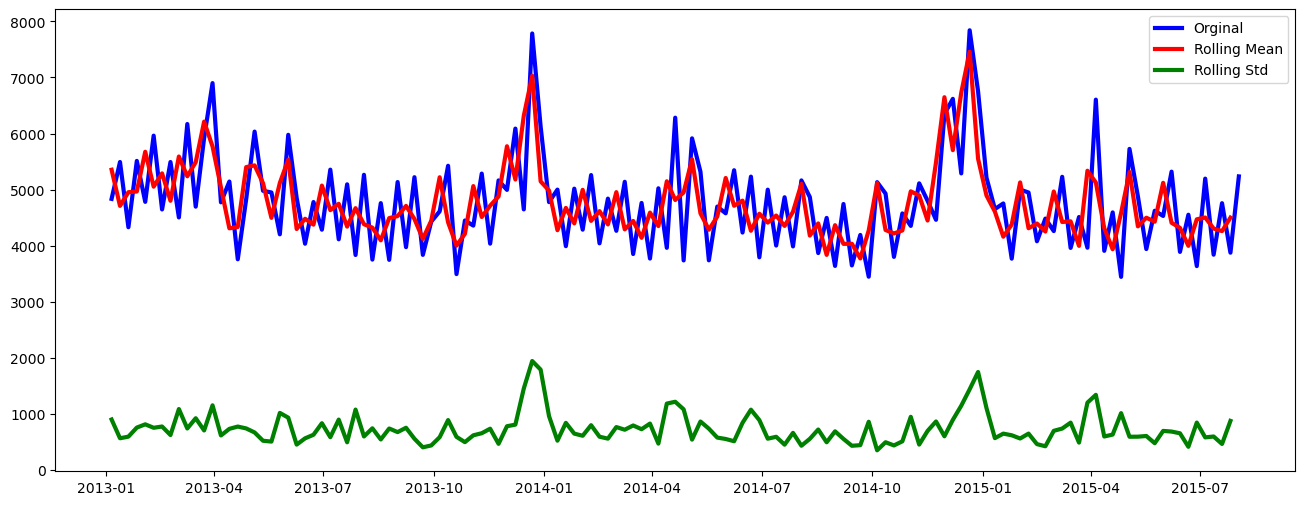

Result of Dickey-Fuller test:
ADF Statestics: -5.412786
P-value: 0.000003
Critical Values:
1% -3.4389045244994096
5% -2.8653156040031176
10% -2.5687805115003


In [97]:
test_stationarity(sales_c)

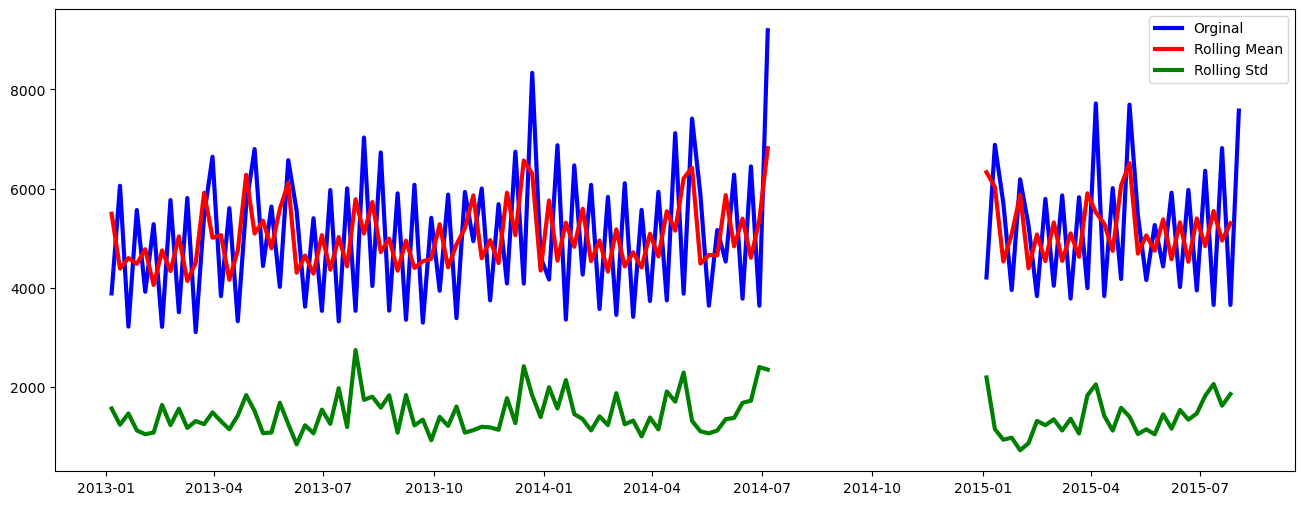

Result of Dickey-Fuller test:
ADF Statestics: -6.321001
P-value: 0.000000
Critical Values:
1% -3.4411511898545206
5% -2.866305414688104
10% -2.569307861950312


In [98]:
test_stationarity(sales_d)

From above charts we could observe that, mean and variance of the data are not change most over time. So, we do not compute any transformation.

# Lets create trends and seasonality

In [101]:
# # plotting trends and seasonality

def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(6)
    fig.set_figwidth(20)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    plt.title('Decomposition Plots')

# def plot_timeseries(sales, StoreType):

#     fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
#     fig.set_figheight(6)
#     fig.set_figwidth(20)

#     decomposition = seasonal_decompose(sales, model='additive', period=180)

#     estimated_trend = decomposition.trend
#     estimated_seasonal = decomposition.seasonal
#     estimated_residual = decomposition.resid

#     axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
#     axes[1].legend(loc='upper left')

#     axes[0].plot(estimated_trend, label='Trend')
#     axes[0].legend(loc='upper left')

#     plt.title(f'Decomposition Plots for Store Type {StoreType}')
# #     plt.show()

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

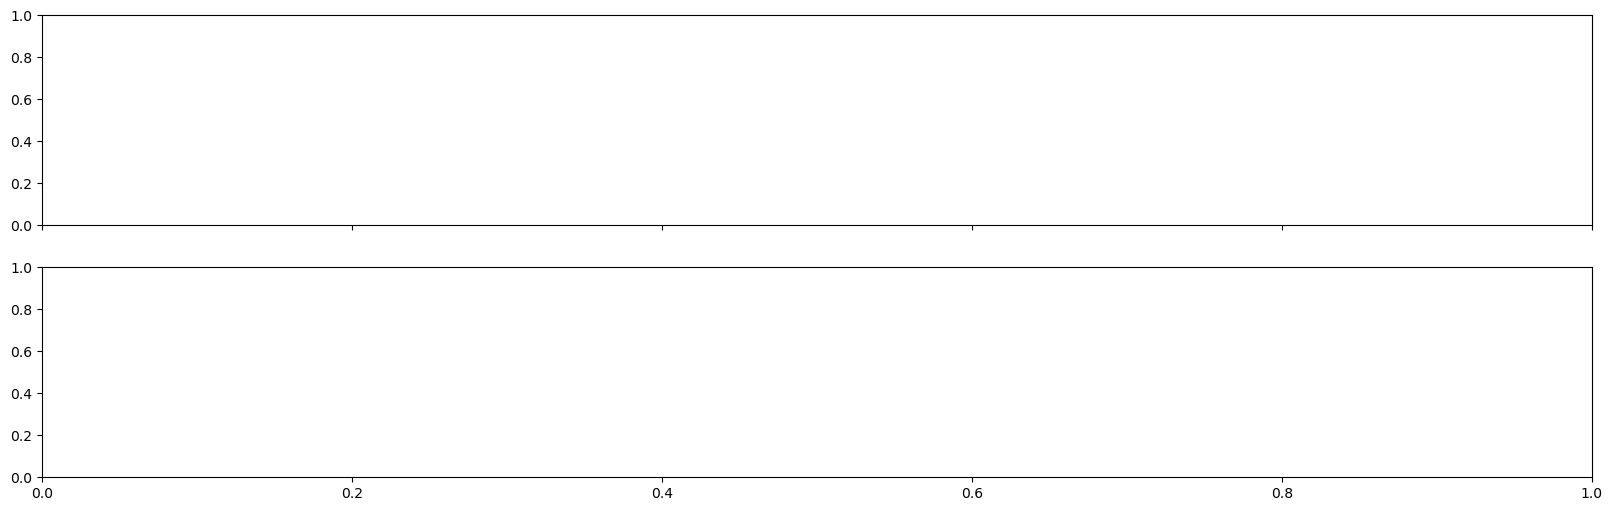

In [102]:
plot_timeseries(sales_a, 'a')
plot_timeseries(sales_b, 'b')
plot_timeseries(sales_c, 'c')
plot_timeseries(sales_d, 'd')

From the above plots, we can see that there is seasonality and trend present in our data. So, we'll use forecasting models that take both of these factors into consideration. For example, SARIMAX and Prophet.

# Time Series Forcusting

## Evaluation Matrics

**1. MAE - Mean Absolute Error:** It is the average of the absolute difference between the predicted values and observed values.
![](https://www.statisticshowto.com/wp-content/uploads/2016/10/MAE.png)

**2. RMSE - Root Mean Square Error:** It is the square root of the average of squared differences between the predicted values and observed values.
![](https://help.innovyze.com/download/attachments/2459040/scadawatch_analytical_function_rmse_formula.png?version=1&modificationDate=1555033531000&api=v2)

# Model 01: Seasonal Autoregressive Integrated Moving Average
In order to use this model, we need to first find out values of **p, d and q. p** represents number of Autoregressive terms - lags of dependent variable.
* q represents number of Moving Average terms
* lagged forecast errors in prediction equation.
* d represents number of non-seasonal differences.

**To find the values of p, d and q - we use Autocorrelation function (ACF) and Partial Autocorrelation (PACF) plots.**

**ACF** measure of correlation between time series with a lagged version of itself.
**PACF** measure of correlation between time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparison.

**p value** is the value on x-axis of PACF where the plot crosses the upper Confidence Interval for the first time.

**q value** is the value on x-axis of ACF where the plot crosses the upper Confidence Interval for the first time.


### Autocorrelation function to make ACF and PACF

In [85]:
def auto_corr(sales):
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')

    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('ACF')

    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('PACF')


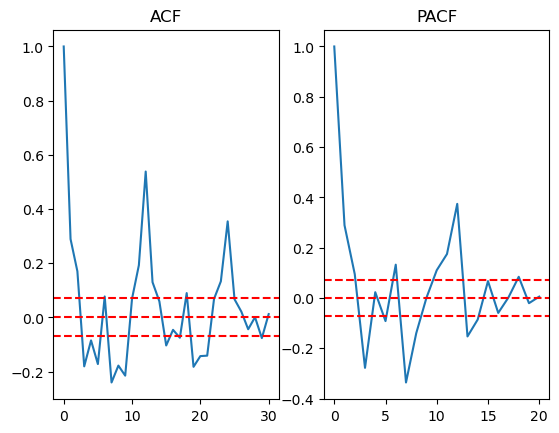

In [86]:
# ACF and PCF for store A
auto_corr(sales_a)

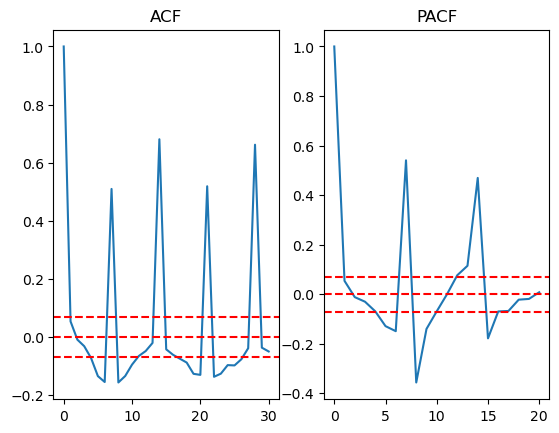

In [87]:
# ACF and PCF for store B
auto_corr(sales_b)

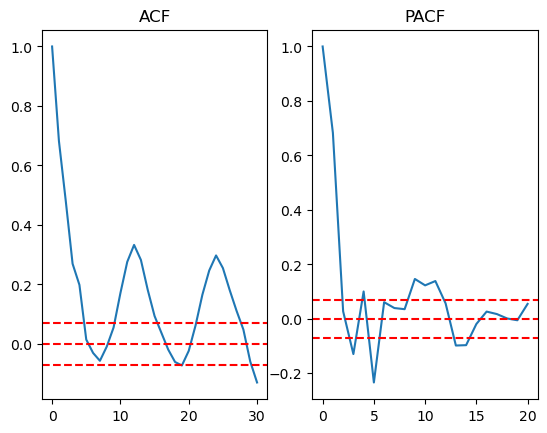

In [88]:
# ACF and PCF for store C
auto_corr(sales_c)

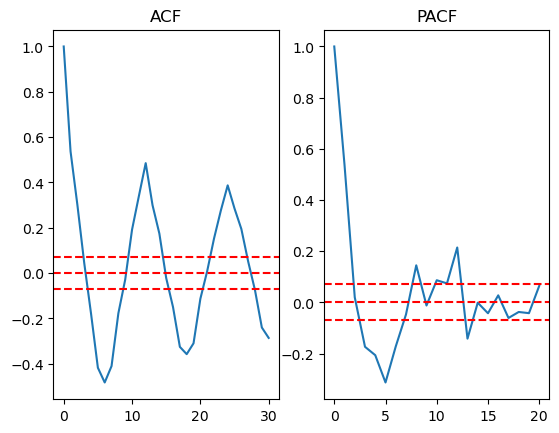

In [44]:
# ACF and PCF for store D
auto_corr(sales_d)

The above graphs suggest that the p = 2 and q = 2 but let's do a grid search and see which combination of p, q and d gives the lowest Akaike information criterion (**AIC**, which tells us the quality of statistical models for a given set of data). Best model uses the lowest number of features to fit the data.

If we are to predict the sales of each store, we need to consider the whole data set rather than one store of each category. We took one store of each category to understand the tiem series data but from now on, we'll use the whole dataset for modelling

In [57]:
# Summering sales on per week basis
# ARIMA = Autoregresive Integrated Moving Average


train_arima = train.resample('w').mean()
train_arima = train_arima[['Sales']]
train_arima.plot()

TypeError: Could not convert aaaaaaaaaaaaaaaaa0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000a0000000000a0 to numeric

In [ ]:
train_arima.head()

### Hyperparamter turing ARIMA model
As discussed above, we have three parameters (p, d and q) for SARIMA model. So, in order to choose the best combination of these parameter, we'll use a grid search. The best combination of parameters will give the lowest AIC score.

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

let's iterate through these combinations to see which one gives the lowest AIC score.

In [ ]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

So, we can see that, the above grid search result our optimal paramiter (ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1807.3489408440882)

### Fitting the model

In [ ]:
# Fitting the data to SARIMA model
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                        order=(1, 1, 1),
                                        seasonal_order=(1,1,1,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_sarima= model_sarima.fit()
print(results_sarima.summary().tables[1])

In [ ]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(16, 10))
plt.show()

We can see from the above 'Histogram plus estimated density' plot that our KDE (Kernel Desnity Estimator) plot closely follows the N(0,1) normal distribution plot. The Normal Q-Q plot shows that the ordered distribution of residuals follows the distribution similar to normal distribution. Thus, our model seems to be pretty good.

**Standardized residual plot tells us that there is no major seasonality trend, which is confirmed by Correlogram (autocorrelation) plot. Autocorrelation plot tells us that the time series residuals have low correlation with lagged versions of itself**

In [ ]:
# Model prediction

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)

# Get confidence interval of forecast
pred_ci = pred.conf_int()

ax = train_arima['2014':].plot(label='Observed', figsize=(15,7))
pred.predicted_mean.plot(ax=ax, label='One step ahed Forecast', alpha=1)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:,1],
               color='r', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima['2015-01-04':]

rms_arima= sqrt(mean_squared_error(train_arima_truth,train_arima_forecasted))
print('Root Mean Squared Error = ',rms_arima)

In [ ]:
# Save your predicted results for future validation.
# You could find this results in output sections

train_arima_forecasted.to_csv('predicted_data.csv')
print('Predicted Data Saved in output')